# Проект: Машинное обучение в бизнесе

# Выбор локации для бурения скважины с помощью модели.

Допустим, мы работаем в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину. 
Шаги для выбора локации обычно такие:

В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;

Строят модель для предсказания объёма запасов в новых скважинах;

Выбирают скважины с самыми высокими оценками значений;

Определяют регион с максимальной суммарной прибылью отобранных скважин.

Нам предоставлены пробы нефти в трёх регионах. Характеристики для каждой скважины в регионе уже известны. 


**Цель исследования:**
1. Построить модель для определения региона, где добыча принесёт наибольшую прибыль;
2. Проанализировать возможную прибыль и риски техникой Bootstrap.



**Ход исследования**

Данные получим из файлов `geo_data_0.csv, geo_data_1.csv, geo_data_2.csv`, 

просмотрим общую информацию о датасетах, оценим качество данных.

Далее приступим к предобработке данных: проверим и исправим ошибки, которые не приведут к искажению конечного результата, оценим их влияние на исследование. 

Затем настанет очередь исследовательского и корреляционного анализа данных.

После этого применим пайплайны для подготовки признаков и обучения модели для каждого региона.

Завершающим этапом исследования будет расчет прибыли и рисков для каждого региона.

Таким образом, иследование будет состоять из следующих этапов:

- [Обзор данных](#info)

- [Предобработка данных](#preprocessing)

- [Исследовательский анализ данных](#EDA)

- [Подготовка данных](#pipeline) 

- [Обучение модели](#model)

- [Расчет прибыли и рисков](#gain)

- [Итоговые выводы](#final)

## Описание данных

Данные геологоразведки трёх регионов находятся в файлах:

`/datasets/geo_data_0.csv, /datasets/geo_data_1.csv, /datasets/geo_data_2.csv`

| | |
| ------ | ------ | 
| **id** | уникальный идентификатор скважины| 
| **f0, f1, f2** | три признака точек|
| **product** | объём запасов в скважине (тыс. баррелей) |

Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

### **Общая информация**
<a id='info'></a>

In [1]:
# Устанавливаем и обновляем необходимые библиотеки
!pip install -Uq scikit-learn phik

In [2]:
# Импротируем необходимые библиотеки
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from scipy import stats as st
from numpy.random import RandomState
sns.set()

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.metrics import mean_squared_error


# Зафиксируем случайность  и размер тестовой выборки
RANDOM_STATE = 42
TEST_SIZE = 0.25
state = RandomState(12345)

sklearn.__version__

'1.6.1'

In [3]:
# Загружаем файлы
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [4]:
# Создаем функцию для получения общей информации
def general_info(df):
    return df.info(), display(df.shape, df.head())

In [5]:
# Посмотрим на первые 5 строк каждого датасета и общую информацию
general_info(geo_data_0)
general_info(geo_data_1)
general_info(geo_data_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(100000, 5)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(100000, 5)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


(100000, 5)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


(None, None)

**Вывод:** Все 3 датафрейма содержат **100000 строк и 5 столбцов**.

В данных пропуски отсутствуют, типы данных корректны.

### **Предобработка данных**
<a id='preprocessing'></a>

#### **Явные дубликаты**

Проверим количество **явных** дубликатов в данных.

In [6]:
display(geo_data_1.duplicated().sum(),geo_data_0.duplicated().sum(),geo_data_2.duplicated().sum())

0

0

0

**Явные** дубликаты не обнаружены.

**Вывод:** таким образом, мы провели предобработку данных и проверили наличие явных дубликатов в данных.

### **Исследовательский анализ данных**
<a id='EDA'></a>

#### **Статистический анализ количественных признаков**

In [7]:
# Выведем статистики количественных признаков
display(geo_data_0.describe(), geo_data_1.describe(), geo_data_2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Во всех признаках минимальные и максимальные значения не имеют аномалий, среднее несильно отличается от медианы. Данные в трех регионах имеют разные диапазоны параметров.

Построим графики для количественных признаков: гистограмму частотности распределения и ящик с усами.

In [8]:
# Определим функцию для построения гистрограммы
def hist_plot(df):
    for col in df.select_dtypes(include='number').columns:
        plt.figure(figsize=(16,7))
        df[col].hist(bins=50)
        plt.grid(True, linestyle='--', color='green', alpha=0.2, which='minor')
        plt.minorticks_on()
        plt.tick_params(which='minor')
        plt.xticks(rotation = 25)
        plt.title(f'Признак {col}')
        plt.xlabel(col)
        plt.ylabel('Количество')
        plt.show()

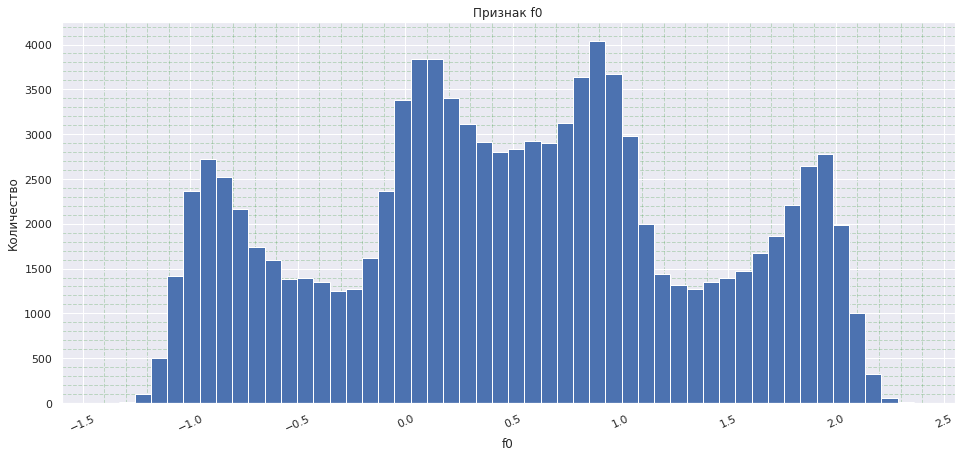

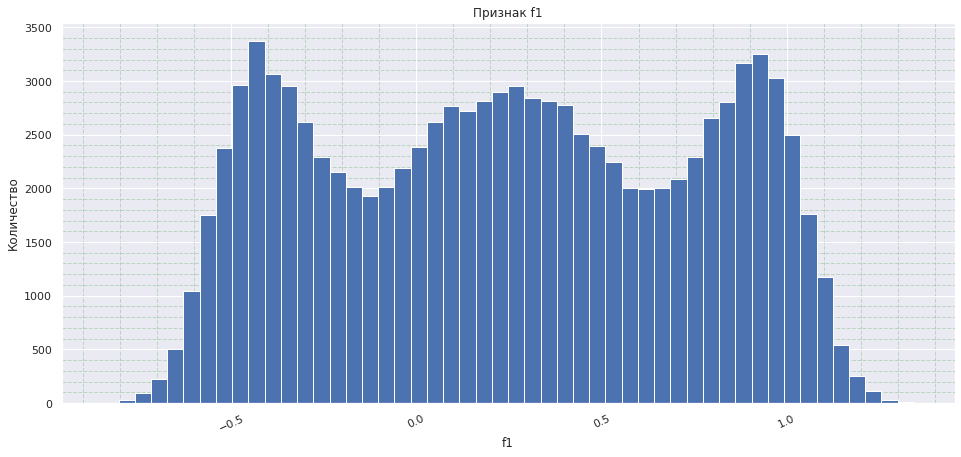

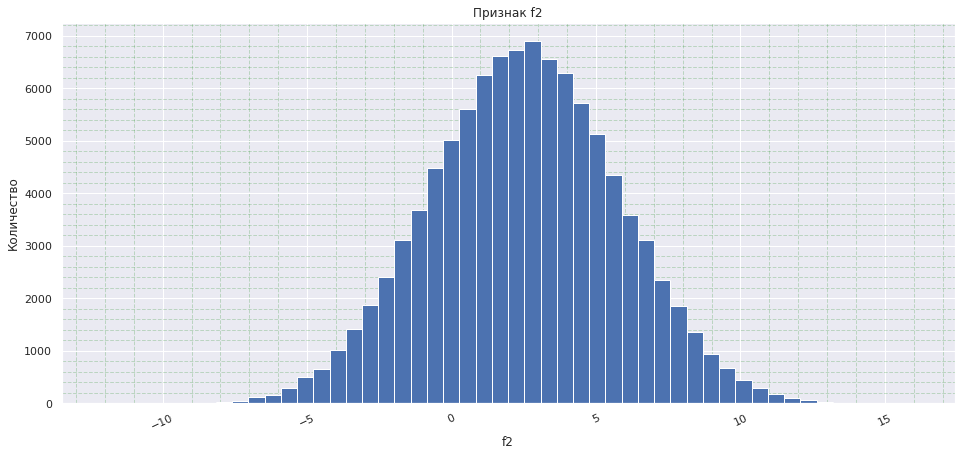

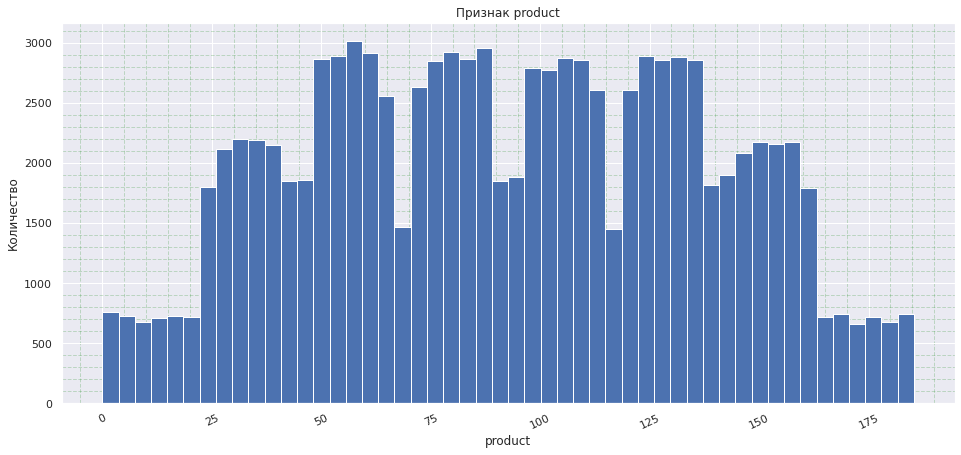

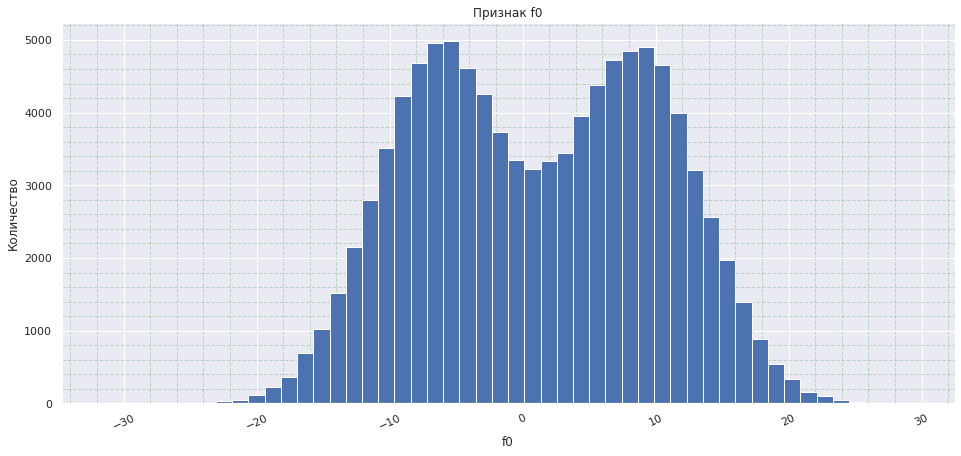

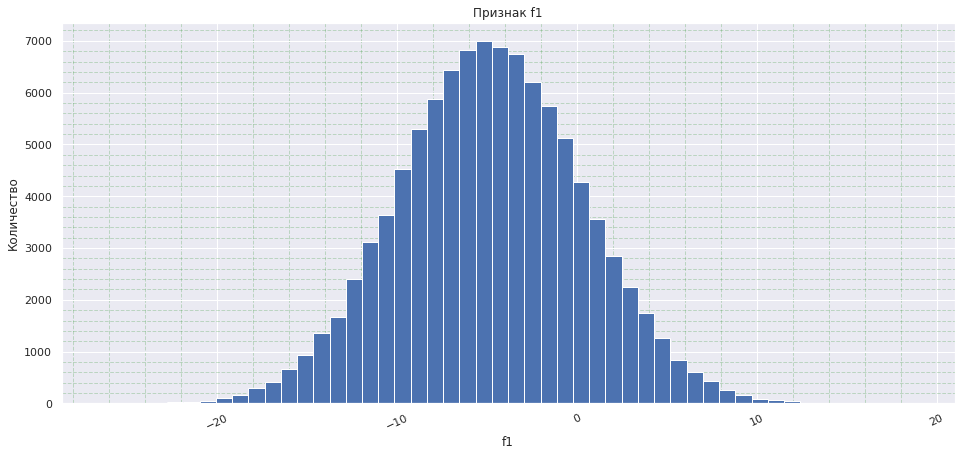

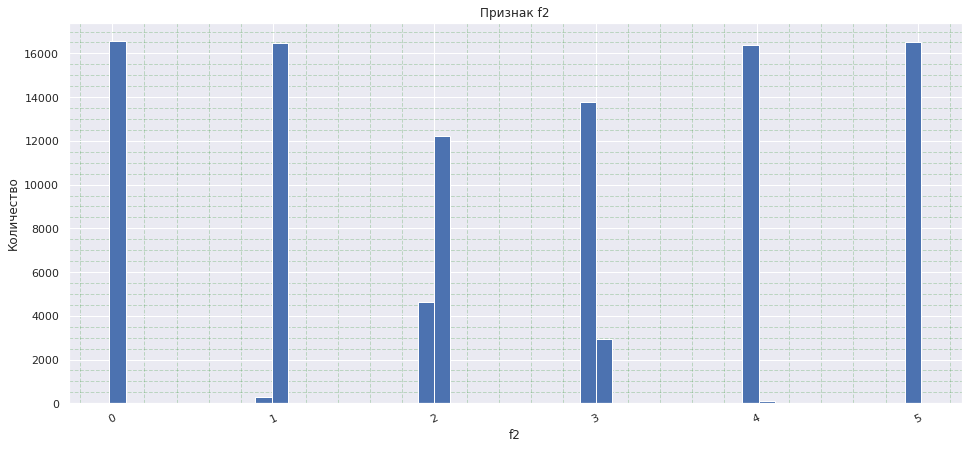

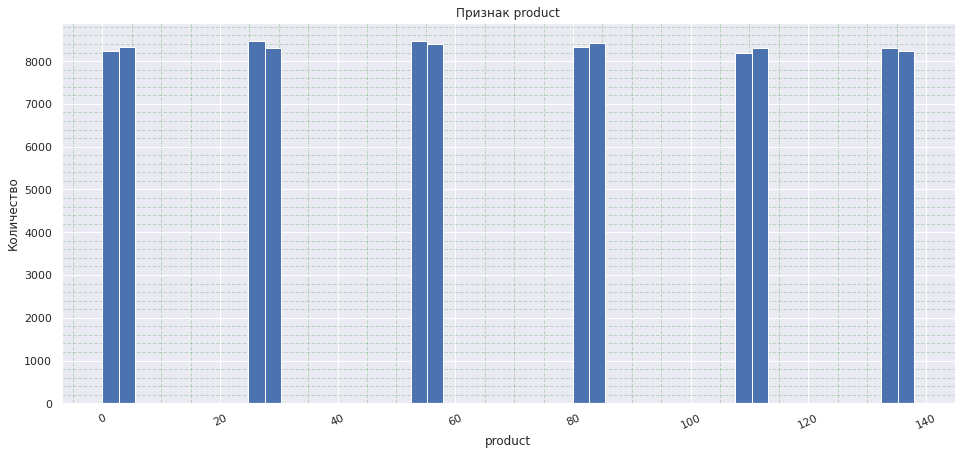

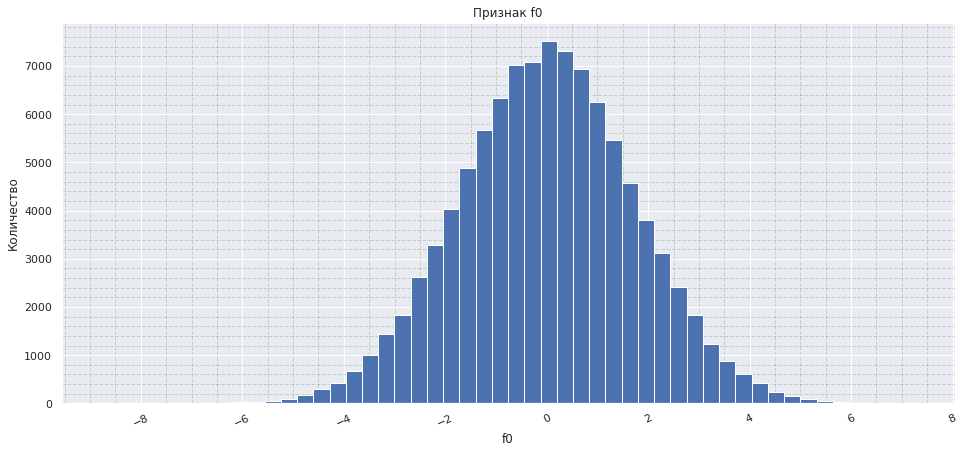

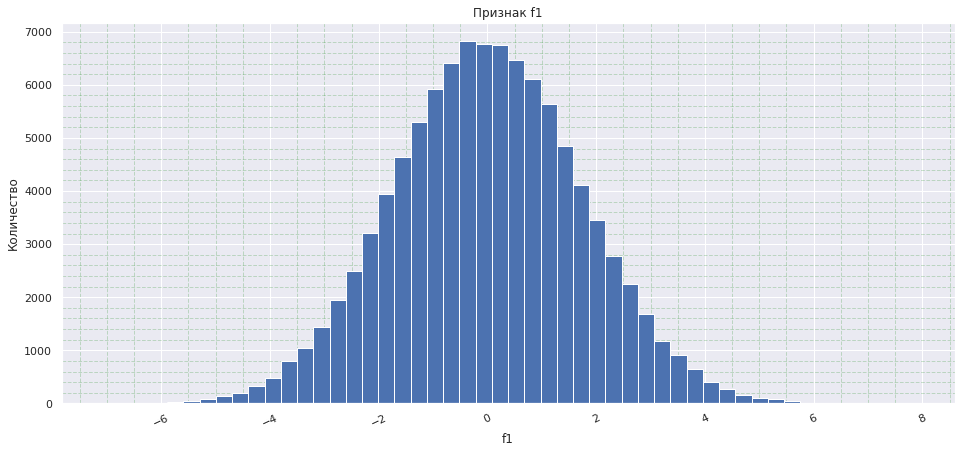

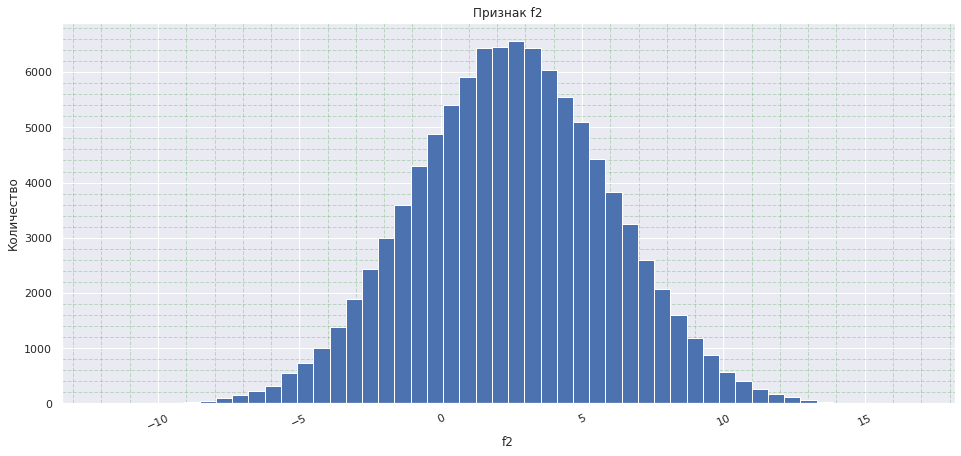

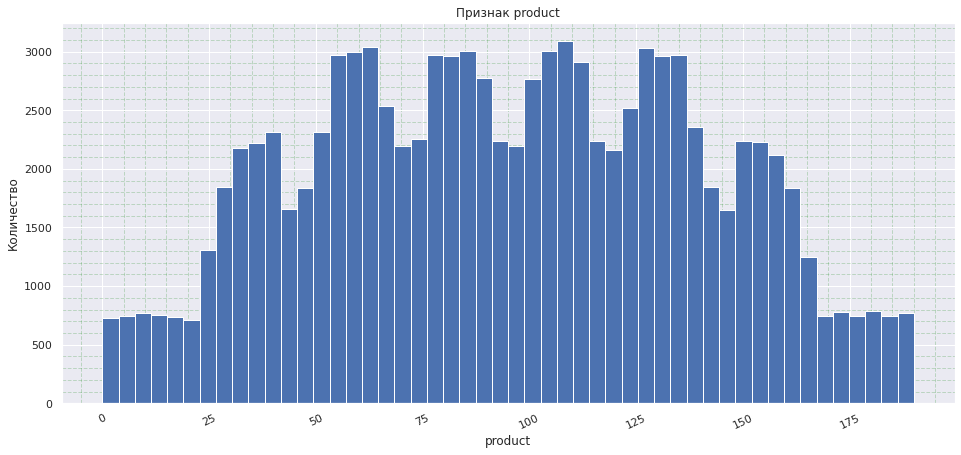

In [9]:
# Строим гистограмму
hist_plot(geo_data_0)
hist_plot(geo_data_1)
hist_plot(geo_data_2)

Признаки не имеют сильных выбросов и аномалий,  

`f2` в 1 регионе, `f1` во 2 регионе и `f0, f1, f2` в 3 регионе имеют вид нормального распределения.

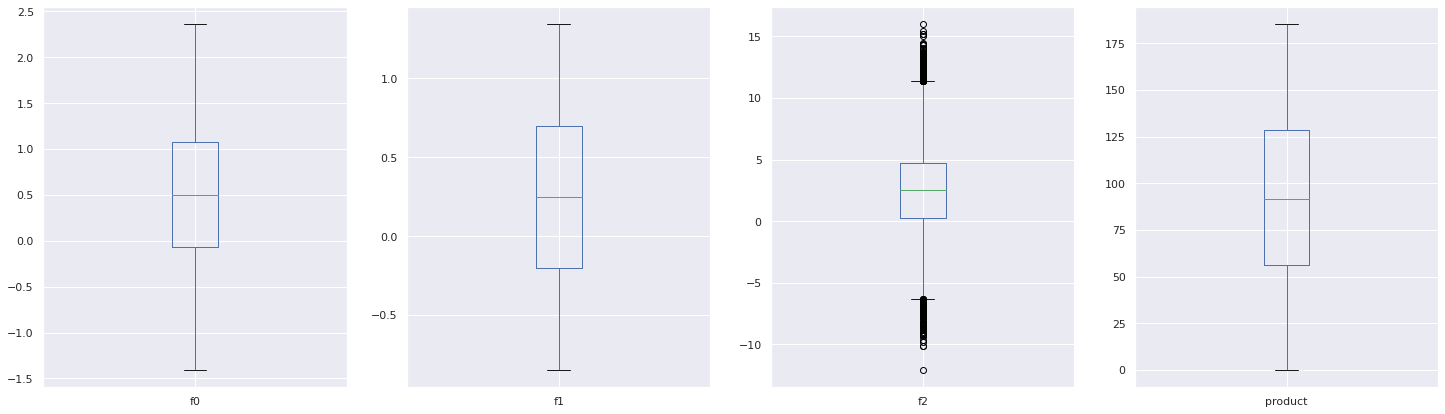

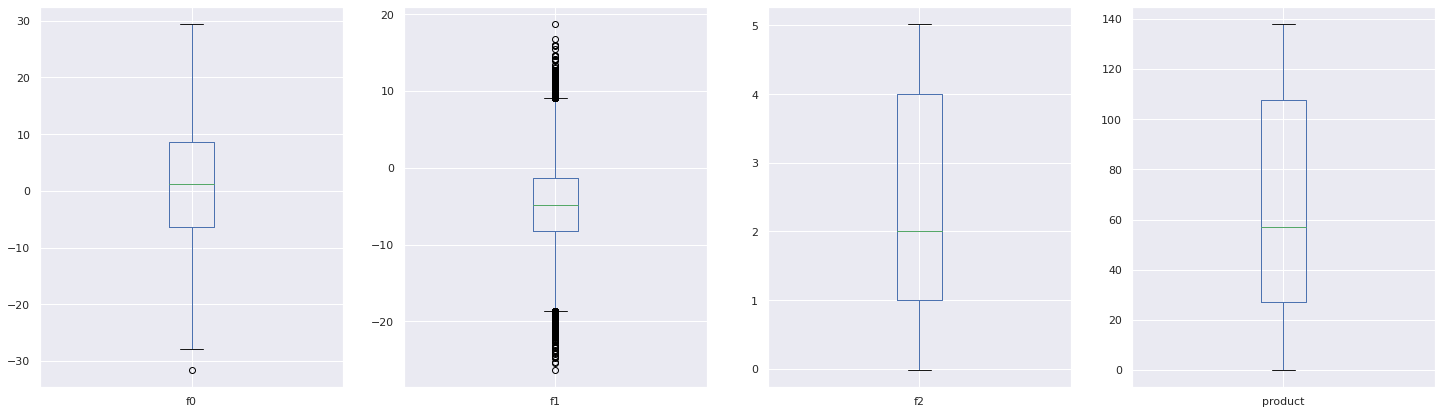

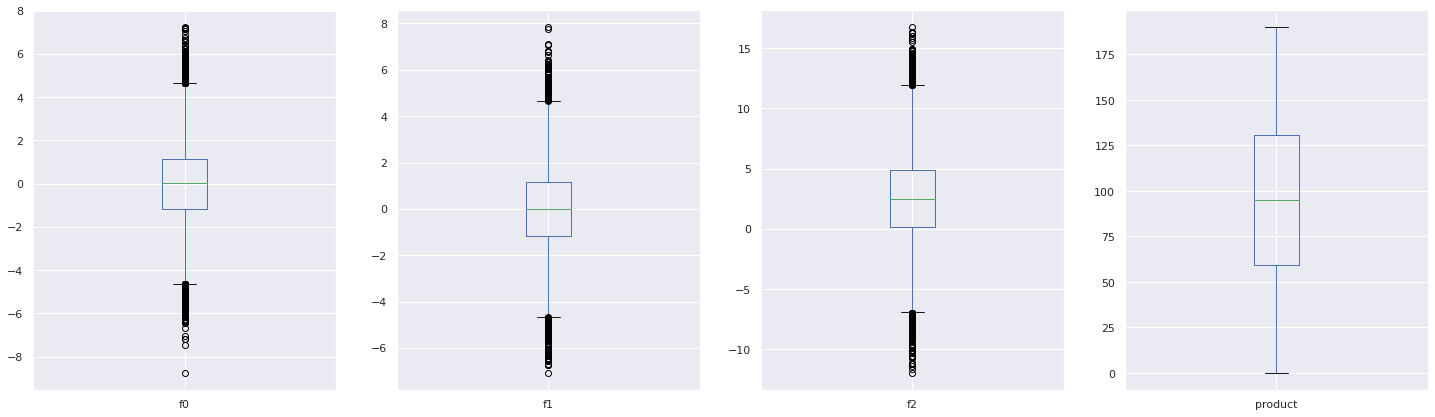

In [10]:
# Строим ящик с усами
geo_data_0.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(25, 7)
)
geo_data_1.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(25, 7)
)
geo_data_2.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(25, 7)
);

В 1 регионе признак `f2`, во 2 регионе признак `f1`, в 3 регионе признаки `f0, f1, f2` имеют много выбросов сверху и снизу, это может быть связано со спецификой параметров.

#### **Корреляционный анализ признаков**

Изучим взаимосвязь между признаками: рассчитаем коэффициенты корреляции между всеми признаками и построим тепловую карту.

In [11]:
corr_0 = geo_data_0.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
corr_1 = geo_data_1.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
corr_2 = geo_data_2.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])

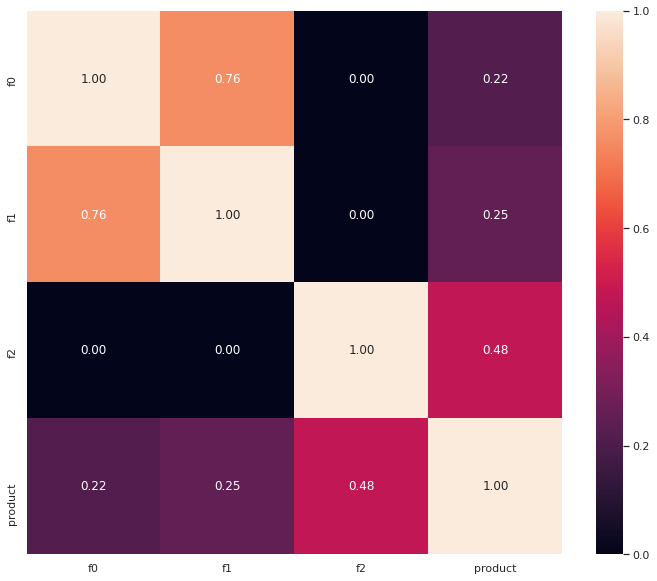

In [12]:
# Построение тепловой карты
plt.figure(figsize=(12, 10))
sns.heatmap(corr_0, annot=True, fmt='.2f');

Мы наблюдаем среднюю прямую связь между целевым признаком и `f2`, а также слабую прямую связь между целевым и `f0, f1`.

**Мультиколлинеарность** между входными признаками **не наблюдается** коэффициент корреляции от 0.9 до 0.95 по модулю отсутствует. 

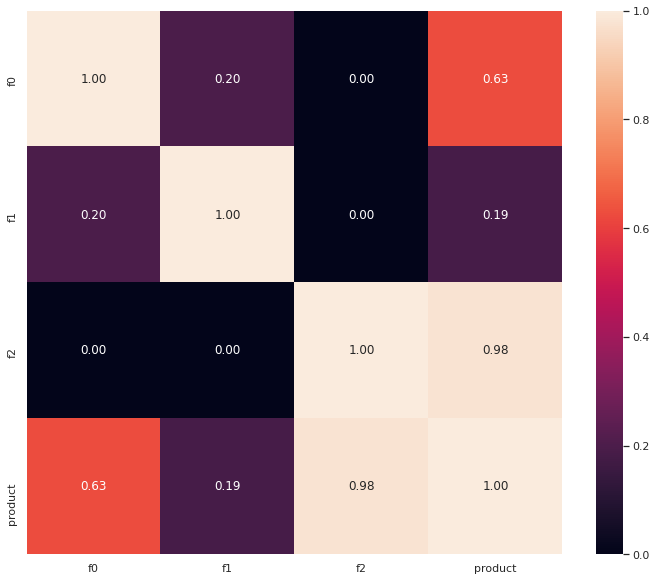

In [13]:
# Построение тепловой карты
plt.figure(figsize=(12, 10))
sns.heatmap(corr_1, annot=True, fmt='.2f');

Мы наблюдаем сильную прямую связь между целевым и `f2`, среднюю прямую связь между целевым признаком и `f0`, а также слабую прямую связь между целевым и `f0`.

**Мультиколлинеарность** между входными признаками **не наблюдается** коэффициент корреляции от 0.9 до 0.95 по модулю отсутствует. 

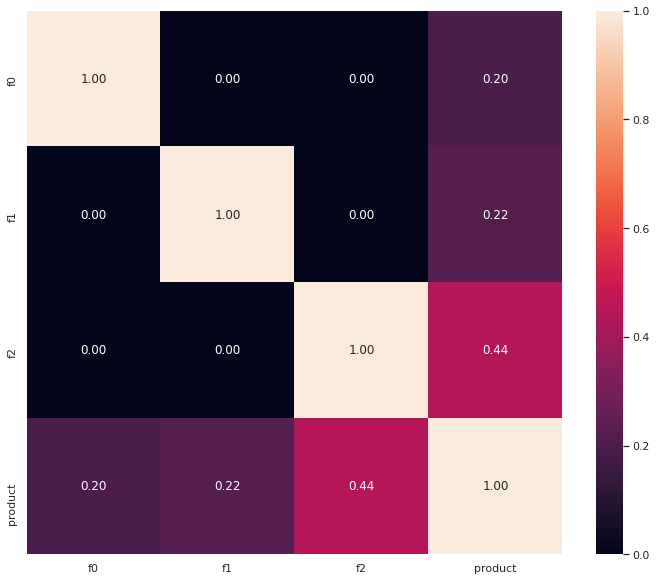

In [14]:
# Построение тепловой карты
plt.figure(figsize=(12, 10))
sns.heatmap(corr_2, annot=True, fmt='.2f');

Мы наблюдаем среднюю прямую связь между целевым признаком и `f2`, а также слабую прямую связь между целевым и `f0, f1`.

**Мультиколлинеарность** между входными признаками **не наблюдается** коэффициент корреляции от 0.9 до 0.95 по модулю отсутствует. 

Посмотрим на взаимосвязь между целевым признаком и входными. Построим диаграммы рассеяния для признака `product` и всех количественных признаков

In [15]:
def scatt_plot(df):
    for col in df.select_dtypes(include=['int','float']).columns:
        if col not in ['product']:
            plt.figure(figsize=(12,7))
            sns.scatterplot(data=df, x='product', y=col);

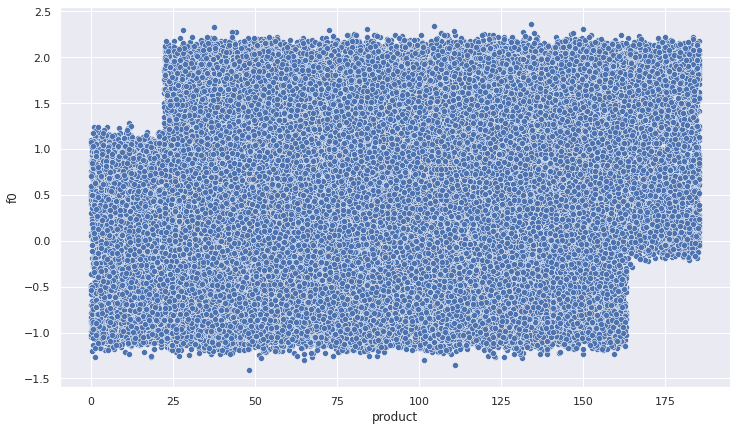

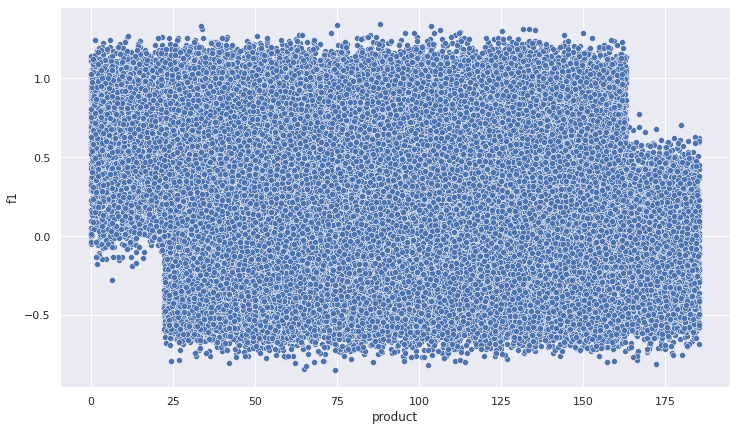

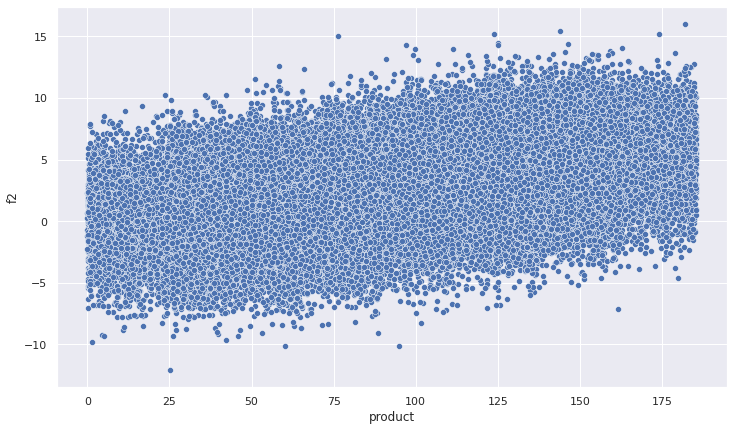

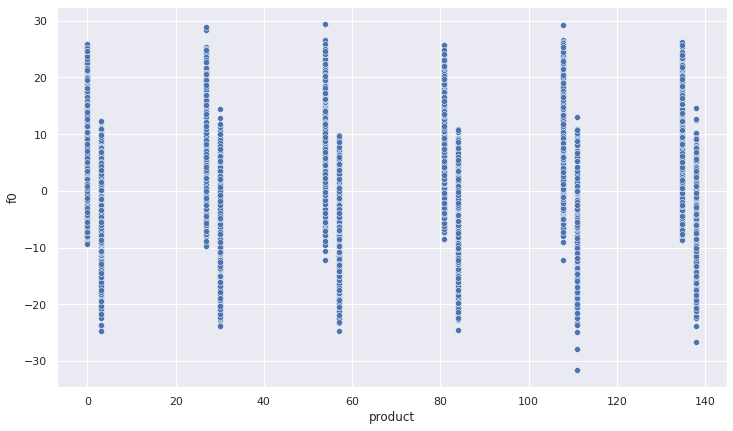

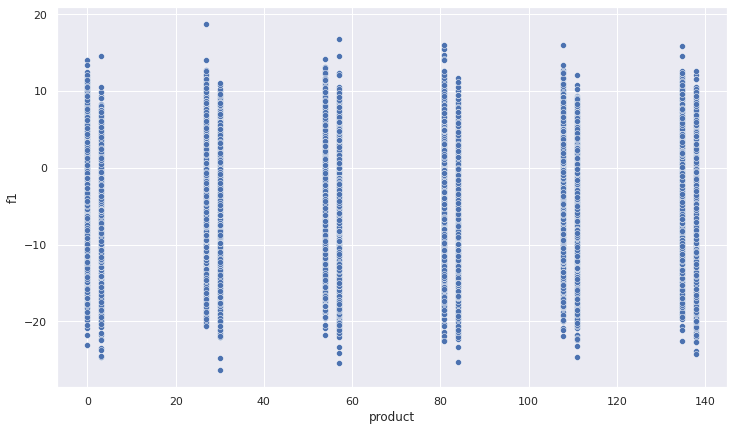

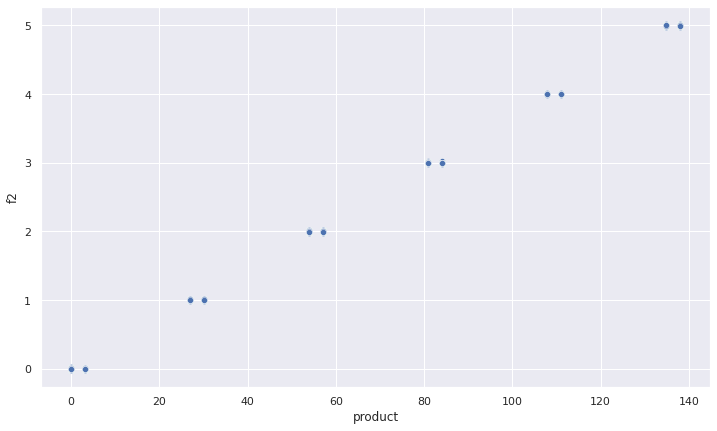

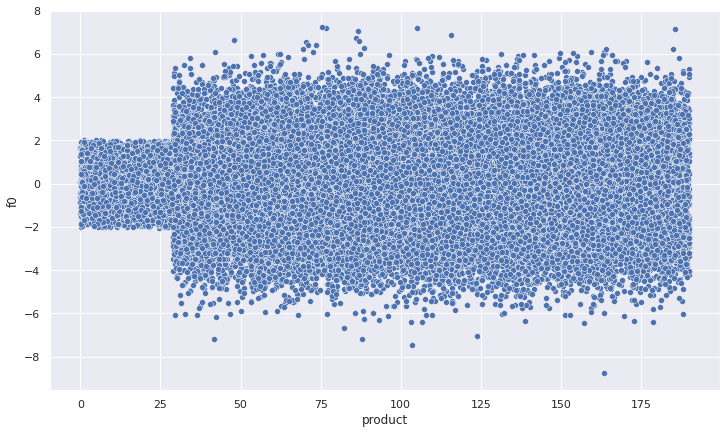

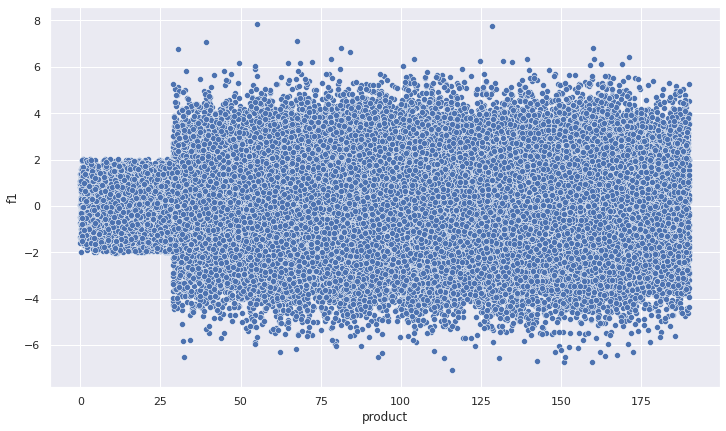

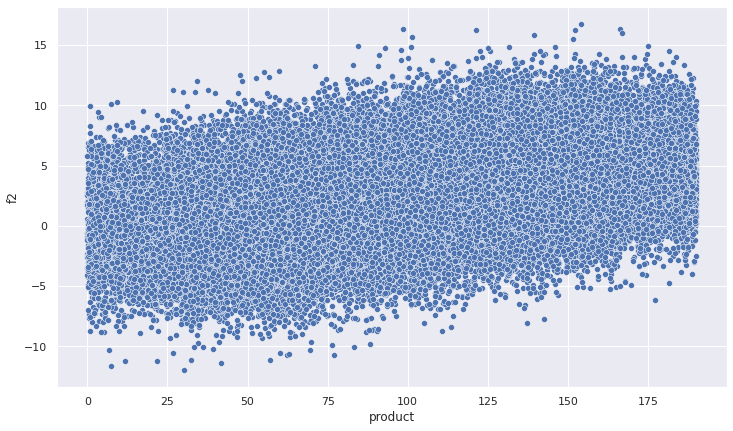

In [16]:
scatt_plot(geo_data_0)
scatt_plot(geo_data_1)
scatt_plot(geo_data_2)

Параметры в 3 регионах имеют линейную зависимость между входными и целевым признаком, что скажется на качестве модели линейной регрессии.

**Вывод:** таким образом, мы провели статистический анализ количественных признаков, а также корреляционный анализ. Аномальные значения не обнаружены, мультиколлинеарность между входными признаками отсутствует, связь между целевым и входными признаками изучена.

### **Подготовка данных**
<a id='pipeline'></a>

Напишем пайплайн для модели линейной регрессии.

In [17]:
# Создаём списки с названиями признаков
num_columns = ['f0','f1', 'f2']

# Создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

# Создаём итоговый пайплайн: подготовка данных и модель
pipe_final= Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LinearRegression())
    ]
)

Разобьем данные каждого региона на на обучающую и валидационную выборки в соотношении 75:25.

In [18]:
# Напишем функцию для разбиения
def split_train_valid(df):
    X, y = df.drop(['product','id'], axis=1), df['product']
    return train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Для первого региона
X_train_0, X_valid_0, y_train_0, y_valid_0 = split_train_valid(geo_data_0)

# Для второго региона
X_train_1, X_valid_1, y_train_1, y_valid_1 = split_train_valid(geo_data_1)

# Для третьего региона
X_train_2, X_valid_2, y_train_2, y_valid_2 = split_train_valid(geo_data_2)

In [19]:
# Проверим разбиение первого региона
X_train_0.shape, y_train_0.shape, X_valid_0.shape, y_valid_0.shape

((75000, 3), (75000,), (25000, 3), (25000,))

In [20]:
# Проверим разбиение второго региона
X_train_1.shape, y_train_1.shape, X_valid_1.shape, y_valid_1.shape

((75000, 3), (75000,), (25000, 3), (25000,))

In [21]:
# Проверим разбиение третьего региона
X_train_2.shape, y_train_2.shape, X_valid_2.shape, y_valid_2.shape

((75000, 3), (75000,), (25000, 3), (25000,))

**Вывод:** таким образом, мы разбили данные на валидационную и тестовую выборку для каждого региона

### **Обучение модели**
<a id='model'></a>

Обучим модель линейной регрессии и константную, и сделаем предсказания на валидационной выборке для каждого региона.

In [22]:
# Константная модель
dummy_regr = DummyRegressor()

# Для первого региона
pipe_final.fit(X_train_0, y_train_0)
dummy_regr.fit(X_train_0, y_train_0)
y_pred_0 = pipe_final.predict(X_valid_0)
y_pred_0 = pd.Series(y_pred_0, index=y_valid_0.index)
y_dummy_pred_0 = dummy_regr.predict(X_valid_0)

# Для второго региона
pipe_final.fit(X_train_1, y_train_1)
dummy_regr.fit(X_train_1, y_train_1)
y_pred_1 = pipe_final.predict(X_valid_1)
y_pred_1 = pd.Series(y_pred_1, index=y_valid_1.index)
y_dummy_pred_1 = dummy_regr.predict(X_valid_1)

# Для третьего региона
pipe_final.fit(X_train_2, y_train_2)
dummy_regr.fit(X_train_2, y_train_2)
y_pred_2 = pipe_final.predict(X_valid_2)
y_pred_2 = pd.Series(y_pred_2, index=y_valid_2.index)
y_dummy_pred_2 = dummy_regr.predict(X_valid_2)

Напечатаем на экране средний запас предсказанного сырья и RMSE модели для каждого региона.

In [23]:
# Для первого региона
print('Средний запас предсказанного сырья для первого региона:', y_pred_0.mean(),'\n',
      'RMSE модели:', np.sqrt(mean_squared_error(y_valid_0, y_pred_0)), '\n',
     'RMSE константной модели на валидационной выборке:', np.sqrt(mean_squared_error(y_valid_0, y_dummy_pred_0)),'\n')

# Для второго региона
print('Средний запас предсказанного сырья для второго региона:', y_pred_1.mean(),'\n',
      'RMSE модели:', np.sqrt(mean_squared_error(y_valid_1, y_pred_1)), '\n',
     'RMSE константной модели на валидационной выборке:', np.sqrt(mean_squared_error(y_valid_1, y_dummy_pred_1)),'\n')

# Для третьего региона
print('Средний запас предсказанного сырья для третьего региона:', y_pred_2.mean(),'\n',
      'RMSE модели:', np.sqrt(mean_squared_error(y_valid_2, y_pred_2)), '\n',
     'RMSE константной модели на валидационной выборке:', np.sqrt(mean_squared_error(y_valid_2, y_dummy_pred_2)),'\n')

Средний запас предсказанного сырья для первого региона: 92.39879990657768 
 RMSE модели: 37.75660035026169 
 RMSE константной модели на валидационной выборке: 44.27723501700235 

Средний запас предсказанного сырья для второго региона: 68.7128780391376 
 RMSE модели: 0.8902801001028846 
 RMSE константной модели на валидационной выборке: 45.94485941764291 

Средний запас предсказанного сырья для третьего региона: 94.77102387765939 
 RMSE модели: 40.145872311342174 
 RMSE константной модели на валидационной выборке: 44.78277680055413 



**Вывод:** таким образом, мы обучили модель линейной регрессии для каждого региона:

| **Регион** | **Средний запас предсказанного сырья** |**RMSE модели**| **RMSE Dummy-модели**|
| ------|------ |------|------|
| **Первый** | 92.4| 37.8|44.3|
| **Второй** | 68.7|0.89|45.9|
| **Третий** | 94.8|40.1|44.8|

Во всех регионах модель показала себя лучше константной, значит все модели не бесполезны.
Наилучшую точность показала себя модель во втором регионе - 0.89, что говорит о надежности и стабильности в ее использовании, она же показала самый низкий средний запас предсказанного сырья - 68.7.

Наилучший показатель запаса сырья у третьего региона - 94.8, однако у него же самая большая метрика RMSE - 44.8. Это может говорить о сопутствующих рисках, которые свойственны таким нестабильным моделям.

На данном этапе можно посоветовать бизнесу присмотреться ко второму региону - самому стабильному.

### **Расчет прибыли и рисков**
<a id='gain'></a>

#### **Подготовка к расчету**

Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины. Для этого учтем следующие условия:

- Бюджет на разработку скважин в регионе — 10 млрд рублей;

- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки;

- Доход с каждой единицы продукта составляет 450 тыс. рублей.

Стоимость одной скважины: 10 млрд/200 скважин = 50 млн рублей, значит доход с одной скважины должен быть **не менее 50 млн рублей.**

Нам необходимо вычислить объем сырья (в тыс. баррелей), каждая единица которого стоит 450 тыс рублей, а в сумме должна составлять не менее 50 млн рублей. Решив несложное неравенство:

объем сырья × 450000 ≥ 50000000,

мы получаем критический порог объема для безубыточности - **111,11 тыс баррелей**.

Сравним полученный объём сырья со средним запасом в каждом регионе. 

| **Регион** | **Средний запас предсказанного сырья** |**Достаточный объём сырья**|
| ------|------ |------|
| **Первый** | 92.4| 111.11|
| **Второй** | 68.7|111.11|
| **Третий** | 94.8|111.11|

Средний запас по всем точкам < 111.11 в каждом регионе, значит в среднем скважины не окупаются. Но здесь мы говорим о всех точках, а не о 200 лучших. Поэтому нельзя сказать, что скважины будут убыточными.

**Вывод:** таким образом, мы провели подготовку к расчету прибыли и посчитали достаточный объем сырья для безубыточной разработки новой скважины, который составляет 111,11 тыс баррелей. Также мы сравнили данный объем со средним запасом предсказанного сырья в каждом регионе и выяснили, что по всем точкам в среднем скважины не окупаются, но это не говорит об их убыточности, так как мы будем брать для разработки 200 лучших точек.

#### **Функция для расчёта прибыли**

Напишем функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:

- выберем скважины с максимальными значениями предсказаний;

- просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям;

- рассчитаем прибыль для полученного объёма сырья.

In [24]:
# Проверим, совпадает ли порядок индексов первого региона
print('Индексы первого региона совпадают' if y_valid_0.index.tolist()==y_pred_0.index.tolist() else 'не совпадают')
# Проверим, совпадает ли порядок индексов второго региона
print('Индексы второго региона совпадают' if y_valid_1.index.tolist()==y_pred_1.index.tolist() else 'не совпадают')
# Проверим, совпадает ли порядок индексов третьего региона
print('Индексы третьего региона совпадают' if y_valid_2.index.tolist()==y_pred_2.index.tolist() else 'не совпадают')

Индексы первого региона совпадают
Индексы второго региона совпадают
Индексы третьего региона совпадают


In [29]:
# Напишем функцию для расчета прибыли
def profit_top_200(target, preds):
    top_200_index = preds.sort_values(ascending=False).head(200).index
    targets_sum = target.loc[top_200_index].sum()
    revenue = targets_sum * 450_000
    profit = revenue - 10_000_000_000
    return profit

Посчитаем прибыль для каждого региона.

In [26]:
# Для первого региона
profit_0 = profit_top_200(y_valid_0, y_pred_0)
print(f'Прибыль топ-200 скважин первого региона: {profit_0 / 1_000_000_000:.2f} млрд руб.','\n')

# Для второго региона
profit_1 = profit_top_200(y_valid_1, y_pred_1)
print(f'Прибыль топ-200 скважин второго региона: {profit_1 / 1_000_000_000:.2f} млрд руб.','\n')

# Для третьего региона
profit_2 = profit_top_200(y_valid_2, y_pred_2)
print(f'Прибыль топ-200 скважин третьего региона: {profit_2 / 1_000_000_000:.2f} млрд руб.','\n')

(200,)
Прибыль топ-200 скважин первого региона: 3.36 млрд руб. 

(200,)
Прибыль топ-200 скважин второго региона: 2.42 млрд руб. 

(200,)
Прибыль топ-200 скважин третьего региона: 2.60 млрд руб. 



**Вывод:** таким образом, мы написали функцию для расчета прибыли топ-200 скважин каждого региона. Наибольшую прибыль показал первый регион: 3.36 млрд рублей, наихудшую показал второй - 2.42 млрд рублей.

Изначально модель предсказывала самый высокий средний запас сырья у первого региона, возможно поэтому предполагаемая прибыль от него наибольшая. Однако стоит учесть еще риски, которые связаны с точностью модели.

#### **Считаем риски и прибыль**

Посчитаем риски и прибыль для каждого региона:
-  Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли;
-  Найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [27]:
# Процедура Bootstrap с 1000 повторений
def bootstrap_1000(target, preds):
    values = []
    for i in range(1000):
        sample_indices = target.sample(n=500, replace=True, random_state=state).index
        sample_indices = np.unique(sample_indices)
        target_subsample = target.loc[sample_indices]
        preds_subsample = preds.loc[sample_indices]
        values.append(profit_top_200(target_subsample, preds_subsample))
        
    values = pd.Series(values)
    mean = values.mean()
    
    lower = values.quantile(0.025)
    upper = values.quantile(0.975)
    
    loss_risk = (values < 0).mean()
    print(f'Средняя прибыль: {mean / 1_000_000_000:.2f} млрд руб.')
    print(f'Доверительный интервал от {lower/ 1_000_000_000:.2f} до {upper/ 1_000_000_000:.2f}')
    print(f'Риск убытков: {loss_risk:.2%}')
    return values

In [30]:
print('Для первого региона:')
bootstrap_values_0 = bootstrap_1000(y_valid_0, y_pred_0)

print('\n','Для второго региона:')
bootstrap_values_1 = bootstrap_1000(y_valid_1, y_pred_1)

print('\n','Для третьего региона:')
bootstrap_values_2 = bootstrap_1000(y_valid_2, y_pred_2)

Для первого региона:
Средняя прибыль: 0.39 млрд руб.
Доверительный интервал от -0.13 до 0.90
Риск убытков: 5.90%

 Для второго региона:
Средняя прибыль: 0.42 млрд руб.
Доверительный интервал от 0.03 до 0.84
Риск убытков: 2.10%

 Для третьего региона:
Средняя прибыль: 0.37 млрд руб.
Доверительный интервал от -0.16 до 0.86
Риск убытков: 7.20%


**Вывод:** после оценки рисков вероятность убытков меньше 2.5% у второго региона, у него же наибольшая средняя прибыль - 420 млн рублей. 

| **Регион** | **Средняя прибыль, млн рублей** |**Доверительный интервал, млн рублей**|**Риск убытков**|
| ------|------ |------|------|
| **Первый** | 390|от -130 до 900|5.9%|
| **Второй** | 420|от 30 до 840|**2.1%**|
| **Третий** | 370|от -160 до 860|7.2%|


Рекомендация бизнесу: разрабатывать **второй регион**. Он обладает стабильной положительной прибылью и риском убытков всего 2.1%, а средняя ожидаемая прибыль — 420 млн рублей. 

### **Итоговые выводы**
<a id='final'></a>

Таким образом мы решили, где бурить новую скважину добывающей компании «ГлавРосГосНефть» и выполнили следующие цели:

1. Построили модель для определения региона, где добыча принесёт наибольшую прибыль;

2. Проанализировали возможную прибыль и риски техникой Bootstrap.

Для этого были выполнены следующие действия:

- **Открыты файлы** с данными и изучена общая информация: 

**`geo_data_0.csv, geo_data_1.csv, geo_data_2.csv`** содержали **100000 строк и 5 столбцов**.


В данных пропуски отсутствовали, типы данных корректны.



- Выполнена **предобработка данных:**
    
    изучили явные дубликаты и устранили.


- Провели **исследовательский анализ данных:**

  проверили аномальные значения и посмотрели на распределение количественных признаков;
  
  провели корреляционный анализ.
  

- Применили пайплайны для подготовки признаков и обучения модели для каждого региона:

    Во всех регионах модель показала себя лучше константной, значит все модели не бесполезны.
    Наилучшую точность показала себя модель во втором регионе - 0.89, что говорит о надежности и стабильности в ее использовании, она же показала самый низкий средний запас предсказанного сырья - 68.7.

     Наилучший показатель запаса сырья у третьего региона - 94.8, однако у него же самая большая метрика RMSE - 44.8. Это может говорить о сопутствующих рисках, которые свойственны таким нестабильным моделям.
     

- Рассчитали прибыль и риски для каждого региона:

    Для первого региона:
    Средняя прибыль: 390 млн руб.
    Доверительный интервал от от -130 до 900 млн руб.
    Риск убытков: 5.9%

    Для второго региона:
    Средняя прибыль: 420 млн руб.
    Доверительный интервал от от 30 до 840 млн руб.
    Риск убытков: 2.1%

    Для третьего региона:
    Средняя прибыль: 370 млн руб.
    Доверительный интервал от -160 до 860 млн руб.
    Риск убытков: 7.2%
    
**Рекомендации для бизнеса:** 

Разрабатывать **второй регион**. Он обладает стабильной положительной прибылью и риском убытков всего 2.1%, а средняя ожидаемая прибыль — 420 млн рублей.

